In [1]:
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np

2022-03-31 19:12:52.411493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 19:12:52.411543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [2]:
version = '9.0.0'
all = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
all.head()

,JPs_FD_ORIVX,LStar_ORIVX_CHI2,Lb_ENDVERTEX_CHI2,LN_Lb_IPCHI2_OWNPV,Lb_PT,LN_Lb_MINIPCHI2,LN_Lb_IP01,LN_Lb_IP23,LN_Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,...,JPs_IP_TOPPV,LStar_IP_ORIVX,JPs_IP_ORIVX,LN_SUM_CONEISO,LN_SUM_IPCHI2,LN_COS_THETA,LN_COS_LBDIRA,Lb_M,IsSimulated,category
0,1.851979,28.907789,28.907789,2.193329,4230.809665,2.193329,-0.847595,-1.041318,-2.872736,0.594733,...,0.352945,0.085317,0.041645,0.265708,6.464721,-5.570637,-0.777264,3998.369168,False,0
1,0.085784,3.052172,3.052172,2.961534,8458.609810,2.961534,-1.916333,-2.378791,-2.722544,0.501596,...,0.092650,0.010171,0.004363,0.989021,5.767648,-4.412842,-0.777397,3908.707715,False,0
2,0.328561,31.440962,31.440962,1.192254,7521.502286,1.192254,-1.315165,-3.398239,-3.880958,0.961206,...,0.033464,0.064917,0.005629,0.546949,5.256708,-5.071058,-0.777203,3925.686564,False,0
3,0.292555,4.659895,4.659895,2.916038,4882.919930,2.916038,-0.328529,-0.747493,-2.750426,0.267760,...,0.473588,0.024150,0.016349,-0.544535,7.818096,-5.766520,-0.777214,4532.655292,False,0
4,0.276511,27.207298,27.207298,2.325226,9988.647107,2.325226,-1.274015,-2.394711,-2.658933,0.962834,...,0.091219,0.030870,0.026209,0.925614,7.154856,-4.088718,-0.777254,4394.754828,False,0


In [3]:
masses = all['Lb_M'][all['category']==1].to_numpy()
# Masses of signal candidate events

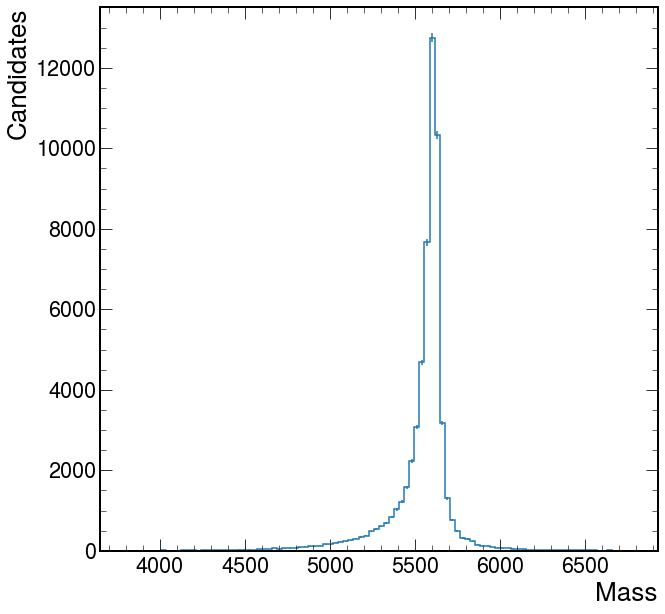

In [4]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

h, bins = np.histogram(masses, bins=100)
fig, ax = plt.subplots(1, 1)
hep.histplot(h, yerr=np.sqrt(h), bins=bins, ax=ax)
plt.xlabel('Mass')
plt.ylabel('Candidates')
plt.show()
# Initial plot

In [5]:
def fitDoubleCB(np_data, label, mass_ranges=[4000, 6500], param_ranges=[[5600, 5500, 5700],[20, 10, 50],[1, 0, 2],[4, 0.1, 10],[1, 0, 2],[4, 0.1, 10],[30000, 0, 100000]]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, *param_ranges[0])
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, *param_ranges[1])
    alpha_l = zfit.Parameter('alpha_l_%s'%label, *param_ranges[2])
    n_l = zfit.Parameter('n_l_%s'%label, *param_ranges[3])
    alpha_r = zfit.Parameter('alpha_r_%s'%label, *param_ranges[4])
    n_r = zfit.Parameter('n_r_%s'%label, *param_ranges[5])
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('DCB_yield_%s'%label, *param_ranges[6], step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return dcb_ext, fitResult, MC_LbM, massObsMC

In [6]:
model, fit, zmasses, obs = fitDoubleCB(masses, "MC")

2022-03-31 19:13:02.258004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 19:13:02.258051: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 19:13:02.258093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-03-31 19:13:02.258754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 19:13:02.328678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [7]:
param_errors = fit.errors()
print(fit.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name            value         minuit_minos    at limit
------------  -------  -------------------  ----------
DCB_yield_MC    58830  -2.4e+02   +2.4e+02       False
alpha_l_MC     0.4599  -  0.013   +  0.013       False
alpha_r_MC       1.16  -  0.028   +  0.026       False
mu_CB_MC         5611  -   0.39   +    0.4       False
n_l_MC          2.571  -  0.034   +  0.035       False
n_r_MC          2.005  -  0.038   +   0.04       False
sigma_CB_MC     22.14  -    0.6   +   0.56       False


Chi2 = 4


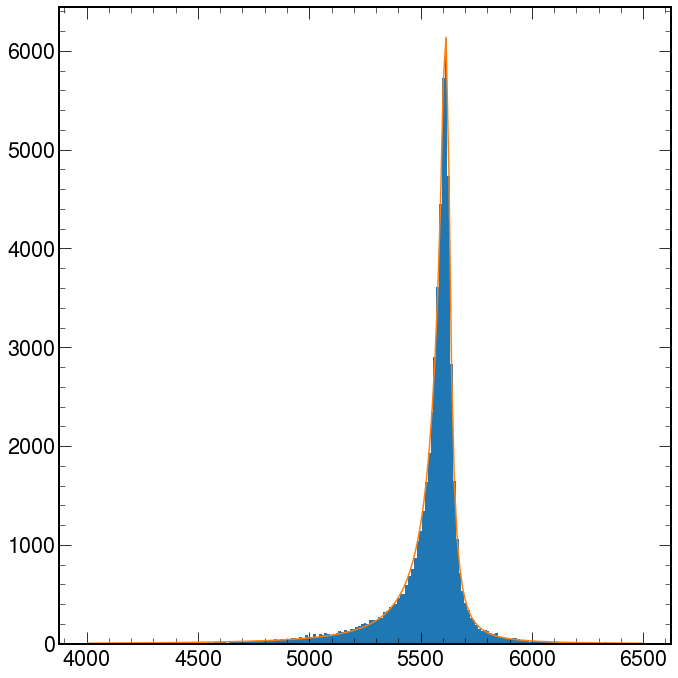

In [30]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

fig, ax = plt.subplots(1, 1)

allLimits = [zmasses.data_range.limit1d[0], zmasses.data_range.limit1d[1]]
allLimits = np.array(allLimits)

xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=200)
x = (xBins[1:]+xBins[:-1]) / 2
y=np.array([])

nBinsLimit=0
for a in range(int(allLimits.shape[0]/2)):
    nBinsLimit+=len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
y = np.append(y, model.pdf(x) * zmasses.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))
y *= 1

data_plot = zfit.run(z.unstack_x(zmasses))
a = ax.hist(data_plot, bins=xBins,label=zmasses.space.obs[0])
scaledDiff=(a[0][a[0]!=0]-y[a[0]!=0])/np.sqrt(a[0][a[0]!=0])
print("Chi2 = %.2g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))))
    
ax.plot(x, y, label='DCB Ext. Model')

plt.tight_layout()
plt.show()

In [31]:
BGSigmaRange = 5

interpRange = np.ones(2)*fit.params["mu_CB_MC"]['value']+np.array([-1*BGSigmaRange,
                            BGSigmaRange])*fit.params["sigma_CB_MC"]['value']

model.integrate(limits=interpRange, norm_range=model.norm_range)*fit.params["DCB_yield_MC"]["value"]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([43073.95219635])>